In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pprint import pprint
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.validation import make_valid
from scipy.spatial import ConvexHull
import math
from concave_hull import concave_hull, concave_hull_indexes
from magic import CircularLinkedList


In [2]:
with open(r"SLAM.pickle", "rb") as input_file:
    e = pickle.load(input_file)

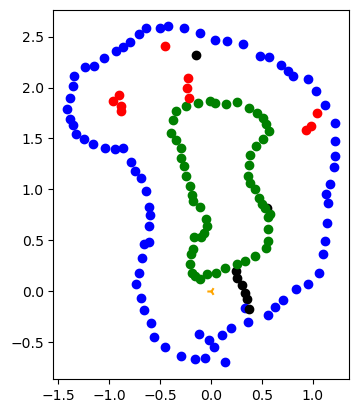

In [3]:
positions=e['positions']
ids=e['ids']
for i,pos_zip in enumerate(zip(positions, ids)):
    # print(pos_zip[1])
    col=pos_zip[1]%3
    if col==0:
        col2='green'
    elif col==1:
        col2='red'
    elif col==2:
        col2='blue'
    if pos_zip[1]<100:
        col2='black'
    plt.scatter(*pos_zip[0], color=col2)

plt.scatter(0,0, color='orange',marker='3',)
plt.gca().set_aspect('equal')
plt.show()

In [4]:
positions_array=np.array(positions)

In [5]:
positions_array=np.array(positions)

mask_external=(ids%3==2) & (ids>=100) & (ids<=1000)
mask_internal = (ids%3==0)& (ids>=100) & (ids<=1000)

ids_external=ids[mask_external]
ids_internal=ids[mask_internal]

positions_external=positions_array[mask_external]
positions_internal=positions_array[mask_internal]


pos_list_ext=[pos for pos in positions_external]
pos_list_int=[pos for pos in positions_internal]

In [6]:
def ordinator(l_input, max_distance=0.4, min_dist=100):
    def dist_nodes(a, b) -> float:
        return np.sqrt(((a-b)**2).sum())
    
    _l_input=l_input
    new_order = []
    point_index = 0
    last = _l_input.pop(point_index)
    new_order.append(last)


    while len(_l_input)>0:
        min_dist = 100
        index = 100
        for i, point in enumerate(_l_input):
            distance_temp = dist_nodes(last, point)
            if distance_temp < min_dist and distance_temp < max_distance:
                min_dist = distance_temp
                index = i

        last = _l_input.pop(index)
        new_order.append(last)
    return new_order

In [7]:
external_ordered = np.array(ordinator(pos_list_ext))
internal_ordered = np.array(ordinator(pos_list_int))

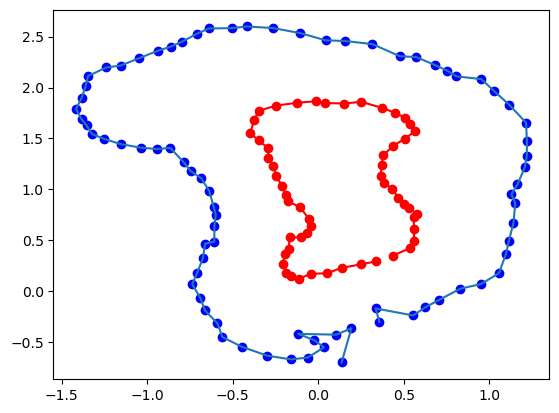

In [8]:
plt.plot(external_ordered[:,0], external_ordered[:,1])
for i in positions_external:
    plt.scatter(*i, c='blue')
plt.plot(internal_ordered[:,0], internal_ordered[:,1], color='red')
for i in positions_internal:
    plt.scatter(*i, c='red')
plt.show()